In [ ]:
import pandas as pd
import ray
from multiprocessing import Process, Pipe
import xgboost as xgb
import numpy as np 
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
from kpal.klib import Profile
from multiprocessing import Queue
from multiprocessing import Process
from Bio.Seq import Seq
from Bio import SeqIO
from multiprocessing import Pool, freeze_support
from scipy.stats import fisher_exact
import subprocess
import re

/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

In [2]:
modelname = 'xgb_trans_15:55:23_4_GSM4041595_K562_rep2.hg38'

In [3]:
p = subprocess.Popen(["ls /home/pitikovegor/CourseWork/genomes/models"], shell = True, stdout=subprocess.PIPE)
out, err = p.communicate()
modelnames_clusters = [i if re.match('xgb_clusters_..:..:.._4', i) else None for i in  out.decode().split('\n')]
modelnames_trpr = [i if re.match('xgb_trans_..:..:.._4', i) else None for i in  out.decode().split('\n')]

In [4]:
modelnames_clusters

[None,
 'xgb_clusters_01:54:14_4_try1',
 'xgb_clusters_10:24:55_4_try4_250_1',
 'xgb_clusters_10:36:58_4_try2_500_10',
 'xgb_clusters_12:03:40_4_try5_250_2',
 None,
 'xgb_clusters_14:47:34_4_try6_250_3',
 None,
 'xgb_clusters_15:41:03_4_try7_500_1',
 'xgb_clusters_16:40:43_4_try8_1000_1',
 None,
 'xgb_clusters_18:24:59_4_try3_1000_10',
 'xgb_clusters_18:38:19_4_try11_6_1_2',
 'xgb_clusters_19:09:06_4_try12_6_1_3',
 'xgb_clusters_20:44:08_4_try9_6_1',
 'xgb_clusters_21:10:12_4_try10_8_1',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [5]:
modelnames_trpr

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 'xgb_trans_06:20:55_4_GSM4041595_K562_rep2.hg38_500_2',
 'xgb_trans_06:59:53_4_GSM4041595_K562_rep2.hg38_250_2',
 'xgb_trans_07:22:39_4_GSM4041595_K562_rep2.hg38_250_1',
 'xgb_trans_08:18:52_4_GSM4041595_K562_rep2.hg38_250_3',
 None,
 None,
 None,
 'xgb_trans_15:55:23_4_GSM4041595_K562_rep2.hg38',
 'xgb_trans_15:55:23_4_GSM4041595_K562_rep2.hg38.txt',
 'xgb_trans_18:01:09_4_GSM4041595_K562_rep2.hg38_6_1_2',
 'xgb_trans_18:09:47_4_GSM4041595_K562_rep2.hg38_6_1_3',
 'xgb_trans_20:04:24_4_GSM4041595_K562_rep2.hg38_6_1',
 'xgb_trans_20:12:51_4_GSM4041595_K562_rep2.hg38_8_1',
 None]

In [6]:
chr_names=['chrX', 'chrY']
for i in range(1, 23):
    chr_names.append('chr%d' % (i))

In [7]:
bst = xgb.Booster({'nthread': 10})
bst.load_model('/home/pitikovegor/CourseWork/genomes/models/%s' % modelname) 

In [8]:
#bst.dump_model('/home/pitikovegor/CourseWork/genomes/models/%s.txt' % modelname)

In [9]:
cell_type = 'K562'
experiment = 'GSM4041593_K562_rep1.hg38'
cont_data_path = '/home/pitikovegor/CourseWork/genomes/reds_experiments/%s/parsed_contacts_%s' % (cell_type, experiment)
sequence_path = '/home/pitikovegor/CourseWork/genomes/chr_sequence'
k = 4

In [10]:
#extract k-mers
def seq_cutter(sequence, position, chain):
    if chain=='+':
        return sequence[max(0, position[0]+1-250) : min(position[1]+1+250, len(sequence))]
    else:
        return sequence[max(0, position[0]+1-250) : min(position[1]+1+250, len(sequence))].reverse_complement()

def open_fasta (name):
    for record in SeqIO.parse(name, "fasta"): # It's a FUCKING GENERATOR!!!!!!! I need in 1st - all of the rest is alternatively
        chr_seq = record.seq
        del record
        return chr_seq
    
def k_mer_counter (k, sequence):
    k_mers_count = max(len(sequence) - k + 1, 1)
    sequence = [sequence]
    k_mers = Profile.from_sequences(sequence, k).counts
    k_mers = np.multiply(k_mers, np.array([1/k_mers_count]*len(k_mers)))
    return k_mers


def sequence_process_rna (fasta_seq, k, input_table):
    chr_seq = open_fasta(fasta_seq)
    input_table = input_table.to_numpy()
    all_kmers = []
    for cont in input_table:
        seq = seq_cutter(chr_seq, (cont[1], cont[2]), cont[3])
        seq = str(seq)
        k_mer_num = list(k_mer_counter(k, seq))
        all_kmers.append(k_mer_num)
    if all_kmers:
        all_kmers = np.array(all_kmers)
        input_table = np.concatenate((input_table, all_kmers), axis=1)
        input_table = input_table[~np.all(input_table[:, 4:] == 0, axis=1)]
        return pd.DataFrame(input_table)
    else:
        return pd.DataFrame(columns = list(range(5+4**k)))

In [11]:
def make_test_sets (contact_data_table, redc_table):
    contacts = pd.read_table(contact_data_table, sep='\t')
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    redc = pd.read_table(redc_table, sep='\t')
    contacts = pd.merge(left=contacts, right=redc[['id', 'is_translate', 'rna_chr', 'rna_bgn', 'rna_end', 'dna_bgn', 'dna_end', 'dna_chr', 'rna_strand', 'dna_strand']], left_on='id', right_on='id', how ='inner')
    del redc
    contacts = contacts[contacts['is_translate']==0].reset_index()
    #contacts = contacts[contacts['rna_chr']!=contacts['dna_chr']]
    contacts['class'] = 0
    return contacts

In [12]:
def all_test_tables(chr_seq, contact_data_table, redc_table, k):
    chr_cont = make_test_sets(contact_data_table,  redc_table)
    kmer = sequence_process_rna(chr_seq, k, chr_cont[['id', 'rna_bgn', 'rna_end', 'rna_strand', 'gene_type']])
    return chr_cont, kmer

In [13]:
all_proc_test = Pool(processes = 24)
all_data = all_proc_test.starmap(all_test_tables, [('%s/%s.fna' % (sequence_path, i), '%s/%s_full_%s.pvalue.tab.gene.txt' % (cont_data_path, i, cell_type), '%s/%s_%s.tsv' % (cont_data_path, i, experiment), k) for i in chr_names])
all_proc_test.close()
all_proc_test.join()

In [14]:
all_contacts = pd.concat([i[0] for i in all_data], ignore_index = True)
all_kmers = pd.concat([i[1] for i in all_data], ignore_index = True)

In [12]:
all_kmers = all_kmers.to_numpy()
full_kmers = xgb.DMatrix(all_kmers[:, 5:])
#preds = bst.predict(full_kmers)
#best_preds = np.asarray([np.argmax(line) for line in preds])



In [15]:
means = {}
for i in gene_types:
    spec = np.count_nonzero((preds_to_type[:, 0] == 1) & (preds_to_type[:, 1] == i))
    nonspec = np.count_nonzero((preds_to_type[:, 0] == 0) & (preds_to_type[:, 1] == i))
    print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
    means[i] = [nonspec, spec]

protein_coding have 6019 specific and 1013240 nonspecific contacts
transcribed_unprocessed_pseudogene have 37 specific and 5097 nonspecific contacts
transcribed_processed_pseudogene have 33 specific and 8437 nonspecific contacts
snoRNA have 43 specific and 4872 nonspecific contacts
scaRNA have 3 specific and 581 nonspecific contacts
snRNA have 37 specific and 5255 nonspecific contacts
ribozyme have 0 specific and 748 nonspecific contacts
polymorphic_pseudogene have 0 specific and 12 nonspecific contacts
processed_pseudogene have 3 specific and 513 nonspecific contacts
TEC have 1 specific and 296 nonspecific contacts
rRNA_pseudogene have 0 specific and 5 nonspecific contacts
IG_V_gene have 0 specific and 3 nonspecific contacts
transcribed_unitary_pseudogene have 6 specific and 1018 nonspecific contacts
unprocessed_pseudogene have 8 specific and 447 nonspecific contacts
unitary_pseudogene have 0 specific and 5 nonspecific contacts
scRNA have 0 specific and 1 nonspecific contacts
misc_RNA

In [83]:
list(means.keys()).sort()

In [20]:
def get_cov_matrix(means, class_rna):
    matrix = [means[class_rna], [sum(means[i][0] if i != class_rna else 0 for i in means.keys()), sum(means[i][1] if i != class_rna else 0 for i in means.keys())]]
    return matrix

In [25]:
cov_mat = get_cov_matrix(means, 'protein_coding')
print('))')
fisher_exact(cov_mat)

))


(1.166612099017181, 6.349381916867621e-08)

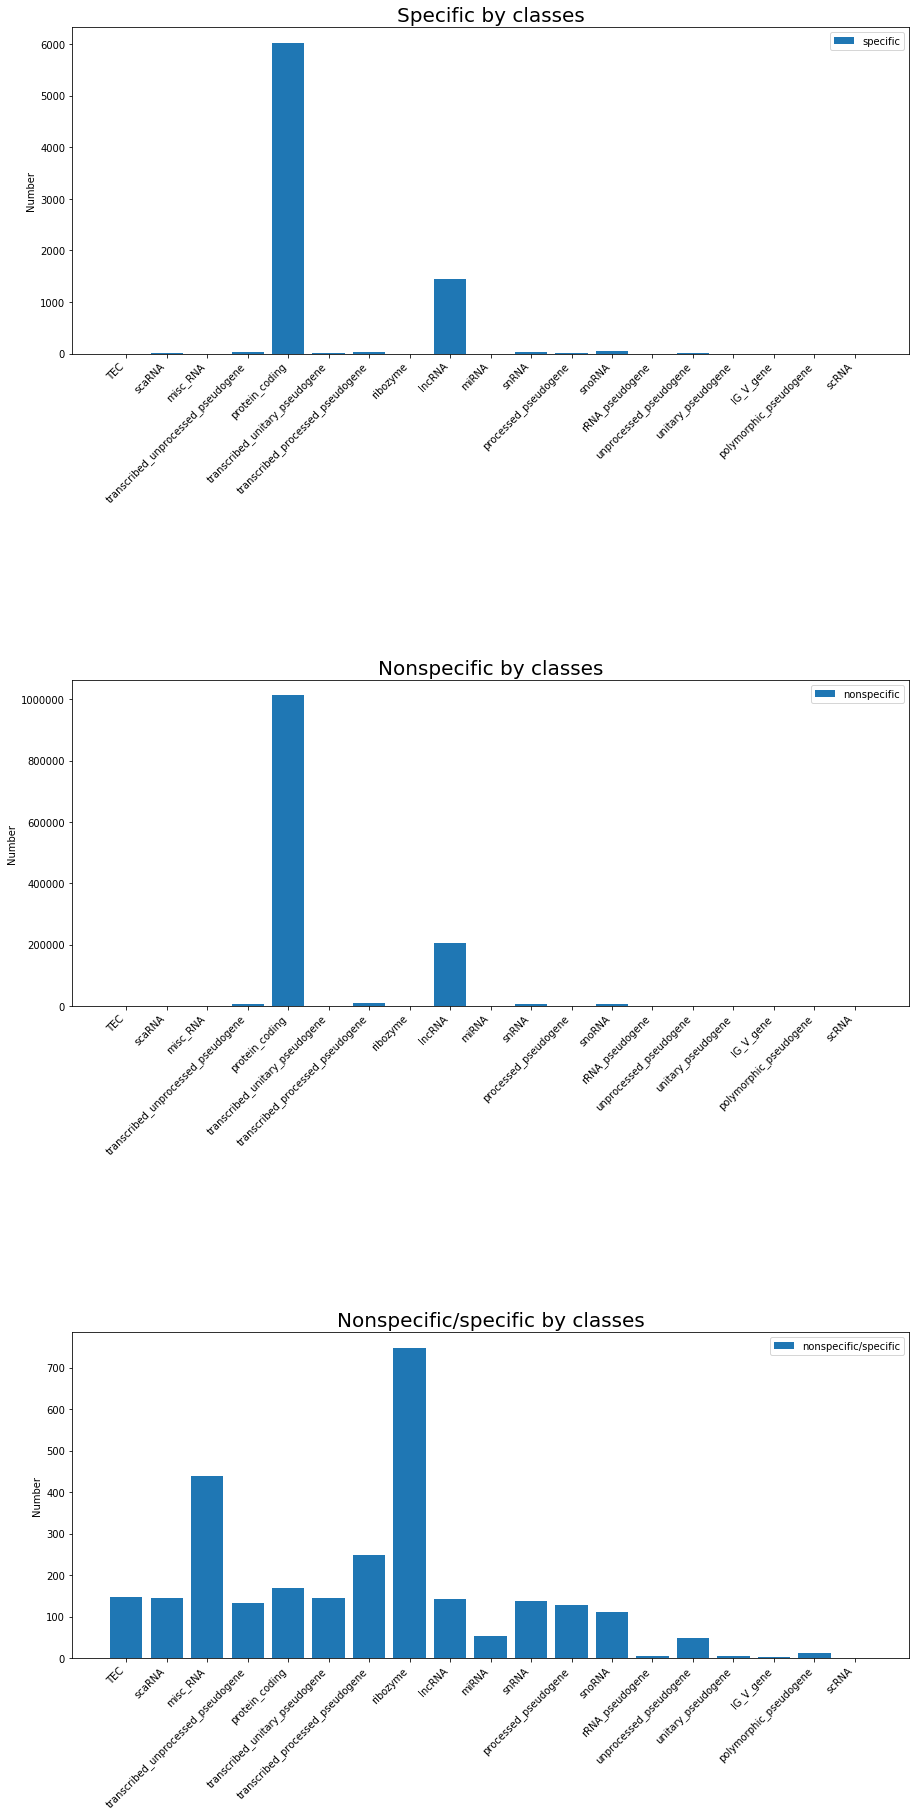

In [122]:
plt.rcParams['axes.titlesize'] = 8
fig = plt.figure(1, figsize=(15, 30))
gs = gridspec.GridSpec(3, 2)
ax0 = fig.add_subplot(gs[0, :])
spec = ax0.bar(np.arange(len(means.keys())), [means[i][1] for i in means.keys()], label='specific')
ax0.set_ylabel('Number')
ax0.set_title('Specific by classes', fontsize=20)
ax0.set_xticks(np.arange(len(means.keys()))) 
ax0.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax0.legend()
ax1 = fig.add_subplot(gs[1, :])
nonspec = ax1.bar(np.arange(len(means.keys())), [means[i][0] for i in means.keys()], label='nonspecific')
ax1.set_ylabel('Number')
ax1.set_title('Nonspecific by classes', fontsize=20)
ax1.set_xticks(np.arange(len(means.keys())))
ax1.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax1.legend()
ax2 = fig.add_subplot(gs[2, :])
nonspec = ax2.bar(np.arange(len(means.keys())), [means[i][0]/(means[i][1]+1) for i in means.keys()], label='nonspecific/specific')
ax2.set_ylabel('Number')
ax2.set_title('Nonspecific/specific by classes', fontsize=20)
ax2.set_xticks(np.arange(len(means.keys())))
ax2.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax2.legend()
plt.subplots_adjust(wspace=2, hspace=1)
plt.savefig('/home/pitikovegor/CourseWork/genomes/pictures/Models/%s_coninfo.png' % modelname)
plt.show()




In [ ]:
for modelname in modelnames:
    bst = xgb.Booster({'nthread': 10})
    bst.load_model('/home/pitikovegor/CourseWork/genomes/models/%s' % modelname) 
    #all_kmers = all_kmers.to_numpy()
    full_kmers = xgb.DMatrix(all_kmers[:, 5:])
    preds = bst.predict(full_kmers)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    best_preds
    preds_to_type = np.concatenate((best_preds[:, np.newaxis], all_kmers[:, 4][:, np.newaxis], all_kmers[:, 0][:, np.newaxis]), axis=1)
    gene_types = list(set(all_kmers[:, 4]))
    means = {}
    for i in gene_types:
        spec = np.count_nonzero((preds_to_type[:, 0] == 1) & (preds_to_type[:, 1] == i))
        nonspec = np.count_nonzero((preds_to_type[:, 0] == 0) & (preds_to_type[:, 1] == i))
        print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
        means[i] = [nonspec, spec]
    cov_mat = get_cov_matrix(means, 'protein_coding')
    fisher_exact(cov_mat)
    plt.rcParams['axes.titlesize'] = 8
    fig = plt.figure(1, figsize=(15, 30))
    gs = gridspec.GridSpec(3, 2)
    ax0 = fig.add_subplot(gs[0, :])
    spec = ax0.bar(np.arange(len(means.keys())), [means[i][1] for i in means.keys()], label='specific')
    ax0.set_ylabel('Number')
    ax0.set_title('Specific by classes', fontsize=20)
    ax0.set_xticks(np.arange(len(means.keys()))) 
    ax0.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
    ax0.legend()
    ax1 = fig.add_subplot(gs[1, :])
    nonspec = ax1.bar(np.arange(len(means.keys())), [means[i][0] for i in means.keys()], label='nonspecific')
    ax1.set_ylabel('Number')
    ax1.set_title('Nonspecific by classes', fontsize=20)
    ax1.set_xticks(np.arange(len(means.keys())))
    ax1.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
    ax1.legend()
    ax2 = fig.add_subplot(gs[2, :])
    nonspec = ax2.bar(np.arange(len(means.keys())), [means[i][0]/(means[i][1]+1) for i in means.keys()], label='nonspecific/specific')
    ax2.set_ylabel('Number')
    ax2.set_title('Nonspecific/specific by classes', fontsize=20)
    ax2.set_xticks(np.arange(len(means.keys())))
    ax2.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
    ax2.legend()
    plt.subplots_adjust(wspace=2, hspace=1)
    plt.savefig('/home/pitikovegor/CourseWork/genomes/pictures/Models/%s_coninfo.png' % modelname)
    plt.show()

In [ ]:
all_pvals = {}

In [84]:
all_pvals_clus = {}

In [15]:
all_kmers = all_kmers.to_numpy()
full_kmers = xgb.DMatrix(all_kmers[:, 5:])

In [17]:
def get_cov_matrix(means, class_rna):
    matrix = [means[class_rna], [sum(means[i][0] if i != class_rna else 0 for i in means.keys()), sum(means[i][1] if i != class_rna else 0 for i in means.keys())]]
    return matrix

In [18]:
for modelname in modelnames_clusters:
    if not modelname:
        continue
    bst = xgb.Booster({'nthread': 10})
    bst.load_model('/home/pitikovegor/CourseWork/genomes/models/%s' % modelname) 
    preds = bst.predict(full_kmers)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    best_preds
    preds_to_type = np.concatenate((best_preds[:, np.newaxis], all_kmers[:, 4][:, np.newaxis], all_kmers[:, 0][:, np.newaxis]), axis=1)
    gene_types = list(set(all_kmers[:, 4]))
    means = {}
    for i in gene_types:
        spec = np.count_nonzero((preds_to_type[:, 0] == 1) & (preds_to_type[:, 1] == i))
        nonspec = np.count_nonzero((preds_to_type[:, 0] == 0) & (preds_to_type[:, 1] == i))
        #print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
        means[i] = [nonspec, spec]
    rna_types = list(means.keys())
    rna_types.sort()
    answ = []
    for i in rna_types:
        answ.append(fisher_exact(get_cov_matrix(means, i))[1])
    all_pvals_clus[modelname] = answ
    
    
    

NameError: name 'all_pvals_clus' is not defined

In [86]:
all_pvals_trpr = {}

In [ ]:
for modelname in modelnames_trpr:
    if not modelname:
        continue
    bst = xgb.Booster({'nthread': 10})
    bst.load_model('/home/pitikovegor/CourseWork/genomes/models/%s' % modelname) 
    #all_kmers = all_kmers.to_numpy()
    full_kmers = xgb.DMatrix(all_kmers[:, 5:])
    preds = bst.predict(full_kmers)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    best_preds
    preds_to_type = np.concatenate((best_preds[:, np.newaxis], all_kmers[:, 4][:, np.newaxis], all_kmers[:, 0][:, np.newaxis]), axis=1)
    gene_types = list(set(all_kmers[:, 4]))
    means = {}
    for i in gene_types:
        spec = np.count_nonzero((preds_to_type[:, 0] == 1) & (preds_to_type[:, 1] == i))
        nonspec = np.count_nonzero((preds_to_type[:, 0] == 0) & (preds_to_type[:, 1] == i))
        print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
        means[i] = [nonspec, spec]
    rna_types = list(means.keys())
    rna_types.sort()
    answ = []
    for i in rna_types:
        answ.append(fisher_exact(get_cov_matrix(means, i))[1])
    all_pvals_trpr[modelname] = answ

protein_coding have 3020 specific and 1016239 nonspecific contacts
transcribed_unprocessed_pseudogene have 17 specific and 5117 nonspecific contacts
transcribed_processed_pseudogene have 17 specific and 8453 nonspecific contacts
snoRNA have 10 specific and 4905 nonspecific contacts
scaRNA have 1 specific and 583 nonspecific contacts
snRNA have 4 specific and 5288 nonspecific contacts
ribozyme have 0 specific and 748 nonspecific contacts
polymorphic_pseudogene have 0 specific and 12 nonspecific contacts
processed_pseudogene have 1 specific and 515 nonspecific contacts
TEC have 0 specific and 297 nonspecific contacts
rRNA_pseudogene have 0 specific and 5 nonspecific contacts
IG_V_gene have 0 specific and 3 nonspecific contacts
transcribed_unitary_pseudogene have 2 specific and 1022 nonspecific contacts
unprocessed_pseudogene have 3 specific and 452 nonspecific contacts
unitary_pseudogene have 1 specific and 4 nonspecific contacts
scRNA have 0 specific and 1 nonspecific contacts
misc_RNA 

In [123]:
preds_to_type = pd.DataFrame(preds_to_type)

In [124]:
preds_to_type = pd.merge(left=preds_to_type, right=all_contacts[['id', 'gene', 'gene_ac']], left_on=2, right_on='id', how ='inner')

In [125]:
preds_to_type = preds_to_type.drop_duplicates()
preds_to_type

,0,1,2,id,gene,gene_ac
0,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:18527:12404,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19
1,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:27924:7073,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19
2,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11189:24626,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19
3,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11949:19953,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19
4,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:17115:4112,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19
...,...,...,...,...,...,...
1379050,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:20963:14307,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16
1379051,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:22798:23265,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16
1379052,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:26090:21638,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16
1379053,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:28153:15083,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16


In [126]:
preds_to_type

,0,1,2,id,gene,gene_ac
0,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:18527:12404,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19
1,0,protein_coding,M01460:89:000000000-AJJ2J:1:1101:27924:7073,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19
2,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11189:24626,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19
3,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:11949:19953,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19
4,0,protein_coding,M01460:89:000000000-AJJ2J:1:1102:17115:4112,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19
...,...,...,...,...,...,...
1379050,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:20963:14307,M01460:89:000000000-AJJ2J:1:2119:20963:14307,ZNRF3,ENSG00000183579.16
1379051,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:22798:23265,M01460:89:000000000-AJJ2J:1:2119:22798:23265,ZNRF3,ENSG00000183579.16
1379052,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:26090:21638,M01460:89:000000000-AJJ2J:1:2119:26090:21638,ZNRF3,ENSG00000183579.16
1379053,0,protein_coding,M01460:89:000000000-AJJ2J:1:2119:28153:15083,M01460:89:000000000-AJJ2J:1:2119:28153:15083,ZNRF3,ENSG00000183579.16


In [127]:
#preds_to_type['gene'] = preds_to_type['gene_x']
#preds_to_type['gene_ac'] = preds_to_type['gene_ac_x']

In [128]:
gene_preds = preds_to_type[['gene', 'gene_ac', 0, 1,]]
gene_preds = gene_preds.rename(columns={0: 'class', 1: 'type'})
gene_preds = gene_preds.groupby(gene_preds.columns.tolist()[::-1]).size()
gene_preds = pd.DataFrame(gene_preds)
gene_preds.reset_index(inplace=True)
gene_preds = gene_preds.rename(columns={0: 'number'})

In [129]:
gene_preds['positive'] = 0
gene_preds['negative'] = 0
gene_preds.loc[gene_preds[gene_preds['class']==1].index, 'positive'] = gene_preds[gene_preds['class']==1].loc[:, 'number']
gene_preds.loc[gene_preds[gene_preds['class']==0].index, 'negative'] = gene_preds[gene_preds['class']==0].loc[:, 'number']
gene_preds.pop('class').drop_duplicates()

0      0
118    1
Name: class, dtype: int64

In [130]:
gene_preds.sort_values(by = 'positive')

,type,gene_ac,gene,number,positive,negative
0,IG_V_gene,ENSG00000211643.2,IGLV5-52,3,0,3
11093,protein_coding,ENSG00000162521.19,RBBP4,177,0,177
11094,protein_coding,ENSG00000162522.11,KIAA1522,46,0,46
11095,protein_coding,ENSG00000162526.7,TSSK3,26,0,26
11096,protein_coding,ENSG00000162542.13,TMCO4,47,0,47
...,...,...,...,...,...,...
3564,lncRNA,ENSG00000227706.4,AL713998.1,49,49,0
17013,protein_coding,ENSG00000131149.19,GSE1,52,52,0
17826,protein_coding,ENSG00000167522.16,ANKRD11,84,84,0
3685,lncRNA,ENSG00000251562.8,MALAT1,91,91,0


In [131]:
gene_preds.to_csv('/home/pitikovegor/CourseWork/genomes/pictures/Models/%s' % modelname)

In [132]:
gene_preds.sort_values(by = 'positive')

,type,gene_ac,gene,number,positive,negative
0,IG_V_gene,ENSG00000211643.2,IGLV5-52,3,0,3
11093,protein_coding,ENSG00000162521.19,RBBP4,177,0,177
11094,protein_coding,ENSG00000162522.11,KIAA1522,46,0,46
11095,protein_coding,ENSG00000162526.7,TSSK3,26,0,26
11096,protein_coding,ENSG00000162542.13,TMCO4,47,0,47
...,...,...,...,...,...,...
3564,lncRNA,ENSG00000227706.4,AL713998.1,49,49,0
17013,protein_coding,ENSG00000131149.19,GSE1,52,52,0
17826,protein_coding,ENSG00000167522.16,ANKRD11,84,84,0
3685,lncRNA,ENSG00000251562.8,MALAT1,91,91,0


In [15]:
trees_strings = bst.get_dump(dump_format='text') 
total_splits = 0
total_trees = len(trees_strings)
for tree_string in trees_strings:
    n_nodes = len(tree_string.split('\n')) - 1
    n_leaves = tree_string.count('leaf')
    total_splits += n_nodes - n_leaves
print(total_splits)
print(total_trees)

1036040
1000
